# Figure: Example song simulation experiments

This figure demonstrates RF estimates and simulated/predicted responses for examples.

In [2]:
from __future__ import print_function, division
import sys
import imp
import os
import numpy as np
from munch import Munch
from dstrf import spikes, strf, filters, simulate
#from corner import corner

# plotting packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("ticks")
sns.set_context("paper", font_scale=0.7)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 1.5
mpl.rcParams['ytick.major.size'] = 1.5
#print(mpl.rcParams.keys())
outdir = os.path.join("..", "figures")
est_clr = ["darkmagenta", "goldenrod", "darkcyan"]
names = ["posp", "tonic", "phasic"]

In [3]:
with open("../config/song_phasic.yml", "rt") as fp:
    cf = Munch.fromYAML(fp)

cf.data.filter.paramfile = os.path.join("..", cf.data.filter.paramfile)
k1, k1t, k1f = simulate.get_filter(cf)
nfreq = cf.data.filter.nfreq
ntau = cf.model.filter.len
ncos = cf.model.filter.ncos
krank = cf.model.filter.rank
kcosbas = strf.cosbasis(ntau, ncos)
stim_dt = cf.data.dt
model_dt = cf.model.dt

 - using params from STRF #24


In [4]:
data = np.load("../results/phasic_24.npz")
w0 = data["mle"]
print("MLE rate and adaptation parameters:", w0[:3])
w1 = np.median(data["samples"], 0)
print("MAP rate and adaptation parameters:", w1[:3])


MLE rate and adaptation parameters: [ 6.05787262 11.5654441  -0.2150408 ]
MAP rate and adaptation parameters: [ 6.07476993 12.19053584 -0.15441786]


### A: true RF and estimate

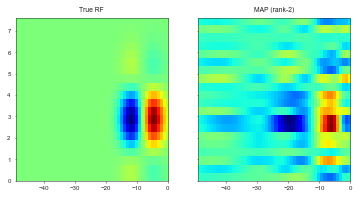

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(6, 3))

axes[0].imshow(k1, extent=(k1t[0], k1t[-1], k1f[0], k1f[-1]), cmap='jet', aspect='auto');
axes[0].set_title("True RF")

rf_map = strf.from_basis(strf.defactorize(w1[3:], nfreq, krank), kcosbas)
axes[1].imshow(rf_map, extent=(k1t[0], k1t[-1], k1f[0], k1f[-1]), cmap='jet', aspect='auto')
axes[1].set_title("MAP (rank-{})".format(krank));

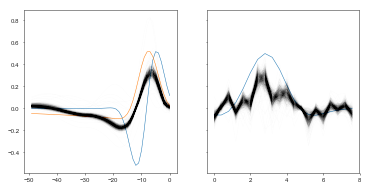

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6, 3))

# plot the factors of the estimate directly
k1ff, k1ft = strf.factorize(k1, 1)
# expected kernel due to the filtering properties of the membrane
km, kmt = filters.exponential(46, 1.0, ntau * cf.data.dt, cf.data.dt)
kconv = np.convolve(km[::-1], k1ft[0,::-1], mode="full")[:km.size][::-1]
kconv *= k1ft.max() / kconv.max()

axes[0].plot(k1t, k1ft[0], label="true")
axes[0].plot(k1t, kconv, label="expected")
axes[1].plot(k1f, k1ff[:, 0], label="true")

samples = data["samples"]
prob = data["prob"]
minprob = np.percentile(prob, 5)
for i in range(prob.size):
    if prob[i] <= minprob: continue
    k_f, k_t = strf.unpack_factors(samples[i, 3:], nfreq, krank)
    k_t = strf.from_basis(k_t, kcosbas)
    axes[0].plot(k1t, k_t[0], 'k', alpha=0.01)
    axes[1].plot(k1f, k_f[:, 0], 'k', alpha=0.01)

In [ ]:
w0 = data["mle"]
print("MLE rate and adaptation parameters:", w0[:3])
w1 = np.median(data["samples"], 0)
print("MAP rate and adaptation parameters:", w1[:3])
rf_map = strf.from_basis(strf.defactorize(w1[3:], cf.data.filter.nfreq, krank), kcosbas)

### A: example stimulus, PSTH, and raster plots

In [ ]:

for row, data in enumerate((d_posp, d_tonic, d_phasic)):
    V = data["tstate"][:, 0]
    stim = data["tstim"]
    tspk = data["tspikes"]
    pspk = data["pspikes"].T
    ntrials = tspk.shape[1]
    fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(1.5, 1.7))
    t_stim = np.linspace(0, cf.data.duration, stim.size) - 1000
    t_resp = np.linspace(0, cf.data.duration, V.size) - 1000

    upsample = int(cf.data.dt / cf.model.dt)
    test_psth = spikes.psth(tspk, upsample, 1)
    pred_psth = spikes.psth(pspk, upsample, 1)

    axes[0].plot(t_stim, stim)
    # axes 1: example voltage response
    axes[1].plot(t_resp, V)
    # axes 2: psth
    axes[2].plot(t_stim, test_psth, linewidth=1, color='k', label="data")
    axes[2].plot(t_stim, pred_psth, linewidth=1, color=est_clr[row], label="pred")
    # axes 3: rasters
    for i in range(ntrials):
        spk_t = np.nonzero(tspk[:, i])[0] * cf.model.dt - 1000
        axes[3].vlines(spk_t, i - 0.4 + ntrials, i + 0.4 + ntrials)
    for i in range(ntrials):
        spk_t = np.nonzero(pspk[:, i])[0] * cf.model.dt - 1000
        axes[3].vlines(spk_t, i - 0.4, i + 0.4, color=est_clr[row])

    axes[3].set_xlim(-10, 3000);
    plt.subplots_adjust(hspace=0.01);
    sns.despine()

    plt.savefig(os.path.join(outdir, "univariate_{}_example.pdf".format(names[row])))

### B: Plot RF and adaptation kernel for all three models

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex='col', figsize=(2.6, 3.0))

ntau = cf.model.filter.len
ncos = cf.model.filter.ncos
kcosbas = strf.cosbasis(ntau, ncos)
k1, kt = filters.gammadiff(ntau * cf.data.dt / cf.data.filter.taus[0],
                           ntau * cf.data.dt / cf.data.filter.taus[1],
                           cf.data.filter.amplitude,
                           ntau * cf.data.dt, cf.data.dt)
# expected kernel due to the filtering properties of the membrane
km, kmt = filters.exponential(46, 1.0, ntau * cf.data.dt, cf.data.dt)
kconv = np.convolve(km, k1, mode="full")[:km.size]

for row, data in enumerate((d_posp, d_tonic, d_phasic)):
    pos = data["pos"]
    prob = data["prob"]
    theta = np.median(pos, 0)

    minprob = np.percentile(prob, 5)

    for i in range(prob.size):
        if prob[i] <= minprob: continue
        k = strf.from_basis(pos[i,3:], kcosbas)[::-1]
        axes[row, 0].plot(k, 'k', alpha=0.01)

    kmap = strf.from_basis(theta[3:], kcosbas)[::-1]
    axes[row, 0].plot(kmap, color=est_clr[row], label="MAP")
    axes[row, 0].plot(kconv * kmap.max() / kconv.max(), 'b', label="expected")

    axes[row, 0].legend()

    # posterior distribution of post-spike kernels
    t = np.arange(0, 400)
    for i in range(prob.size):
        if prob[i] <= minprob: continue
        axes[row, 1].plot(t, 
                 - pos[i,1] * np.exp(-t / cf.model.ataus[0]) - pos[i,2] * np.exp(-t / cf.model.ataus[1]),
                 'k', alpha=0.01)
    axes[row, 1].plot(t, - theta[1] * np.exp(-t / cf.model.ataus[0]) - theta[2] * np.exp(-t / cf.model.ataus[1]), 
                      color=est_clr[row], label="MAP")
    axes[row, 1].legend()
    
sns.despine()
# for ax in axes.flat:
#     ax.tick_params(length=1)
plt.subplots_adjust(wspace=0.3);
plt.savefig(os.path.join(outdir, "univariate_rfs.pdf"))

### C: corner plots

Doesn't appear possible to overlay the plots directly, so plot each separately and then recombine in illustrator.

In [ ]:
matlabs = ['w','a1','a2']
ranges = [(5, 16), (-10, 130), (0,2)]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(3, 3))
for data, row in [(d_phasic, 2), (d_tonic, 1), (d_posp, 0)]:
    c = corner(data["pos"][:, :3],
               fig=fig,
               color=est_clr[row],
               range=ranges,
               bins=50, smooth=2,smooth1d=0,
               labels=matlabs)

for ax in axes.flat:
    ax.tick_params(labelrotation=0)
plt.savefig(os.path.join(outdir, "univariate_corner.pdf"))